# Project: Construction of Low and High Correlation Portfolios of Risky Assets 
In this `project,` we'll explore how the correlation of asset return influences the `efficient frontier` computed by solving the minimum variance allocation problem initially proposed by [Markowitz, 1952](https://www.jstor.org/stable/2975974). Correlation is crucial in minimum variance portfolio allocation as it affects diversification. 
* A low correlation between assets reduces overall portfolio risk by offsetting losses and gains. Correlation also shapes the efficient frontier; lower correlations widen the efficient frontier, providing investors with more opportunities for portfolios with varying risk and return.

Let's test this conjecture by computing the efficient frontier for low and high-correlation portfolios.

### Learning objectives
In this `project,` you'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for a portfolio of risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. However, unlike the worked example in this module, in this `project,` you'll construct `low` and `high` correlation portfolios and compare the respective efficient frontiers of each. 

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-01-2023`.
* __Task 1__: We'll compute `low` and `high` correlation ticker collections next.
    * `Check`: Verify the `correlated_ticker_pairs` dictionary data
    * `TODO`: 
* __Task 2__: Then, we'll compute the efficient frontier for the `high` correlation collection of tickers:
    * `TODO`: minimize the risk for a specified minimum reward value, visualize the efficient frontier, and look at some sample portfolios on the `high` correlation efficient frontier.
* __Task 3__: Then, we'll compute the efficient frontier for the `low` correlation collection of tickers:
  * `TODO`: minimize the risk for a specified minimum reward value, visualize the efficient frontier, and look at some sample portfolios on the `low` correlation efficient frontier.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Installed MultivariateStats ─ v0.10.3
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-1/Project.toml`
    Updating `~/Desktop/julia_work/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `10-31-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `list_of_all_tickers` array

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;
number_of_tickers = length(list_of_all_tickers);

### Compute the covariance and expected return for all firms in the dataset
The expected growth $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll need to compute values for both of these quantities for the entire data set (all `N = 459` tickers), and then we'll filter out which tickers we are interested in. 

* First, we compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [13]:
all_firms_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, Δt = (1.0/252.0));

* Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the [mean(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean), which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ to the array `μ`:

In [15]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

* Estimate the annualized `covariance_matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cov(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [17]:
Σ = cov(all_firms_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

* Estimate the annualized `correlation matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cor(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $ρ$ variable:

In [19]:
ρ = cor(all_firms_return_matrix) # correlation matrix

460×460 Matrix{Float64}:
 1.0       0.300001  0.301695  0.479962  …  0.48165   0.333841  0.581071
 0.300001  1.0       0.304549  0.317579     0.36358   0.461435  0.29548
 0.301695  0.304549  1.0       0.254655     0.308162  0.359682  0.339325
 0.479962  0.317579  0.254655  1.0          0.47834   0.253979  0.52406
 0.304411  0.151737  0.223867  0.267654     0.191234  0.211721  0.363022
 0.5611    0.193803  0.230915  0.446208  …  0.37737   0.227813  0.55824
 0.557203  0.368804  0.374852  0.577663     0.51357   0.403288  0.597762
 0.497469  0.220908  0.22843   0.592591     0.473501  0.191866  0.517024
 0.534947  0.427773  0.298274  0.565422     0.545263  0.378167  0.489485
 0.352345  0.380973  0.320304  0.31355      0.338222  0.483813  0.321355
 0.486248  0.3863    0.367593  0.481361  …  0.451597  0.394284  0.55267
 0.547685  0.352786  0.289148  0.542806     0.523489  0.297925  0.510328
 0.312193  0.164855  0.256664  0.290533     0.215522  0.222574  0.405913
 ⋮                            

## Task 1: Compute `low` and `high` correlation ticker collections
Let's begin by computing `low` and `high` correlation partners for each ticker in the `list_of_all_tickers` array. We begin by initializing storage for the correlation data in the `correlated_ticker_pairs::Dict{String, Array{Tuple{String, String, Float64},1}}` dictionary. We populate this dictionary using a `for-loop` over the `list_of_all_tickers.` For each ticker:
* We access the ticker at index `i` from the `list_of_all_tickers`. We then access the corresponding row in the covariance matrix `Σ` and then sort using the [Julia sortperm(...) function](https://docs.julialang.org/en/v1/base/sort/#Base.sortperm). This function returns the permutation vector that will sort the covariance entries from `smallest` to `largest.` Finally, we generate a list of tickers sorted by correlation in ascending order for each value of `test_ticker` using an [array comprehension operation](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions) in combination with the [Julia pipe operation](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We store both the ticker and the entry of the covariance matrix:

In [21]:
correlated_ticker_pairs = Dict{String, Array{Tuple{String,String,Float64},1}}();
for i ∈ eachindex(list_of_all_tickers)
    test_ticker = list_of_all_tickers[i];
    id = sortperm(ρ[i,:])
    [(test_ticker, list_of_all_tickers[id[j]],ρ[i,id[j]]) for j ∈ eachindex(id)] |> tuple -> correlated_ticker_pairs[test_ticker] = tuple;
end

For example, to see the ordered collection of tickers organized from the smallest to the largest correlation) for [Goldman Sachs](https://www.goldmansachs.com/) (with ticker symbol `GS`), pass the ticker into the `correlated_ticker_pairs` dictionary:

In [23]:
correlated_ticker_pairs["GS"] # pass ticker symbol as a String into the dictionary

460-element Vector{Tuple{String, String, Float64}}:
 ("GS", "GLD", -0.00774873425485847)
 ("GS", "CLX", 0.002608557892717759)
 ("GS", "CHD", 0.045698203400386474)
 ("GS", "CPB", 0.05631839041451237)
 ("GS", "KR", 0.0649482718824888)
 ("GS", "UNG", 0.09958363808345415)
 ("GS", "NEM", 0.10491578097749991)
 ("GS", "GIS", 0.11696662109658824)
 ("GS", "HRL", 0.12335261090836766)
 ("GS", "SJM", 0.1250152835013001)
 ("GS", "KMB", 0.14342732330021785)
 ("GS", "SLV", 0.14649618092633845)
 ("GS", "REGN", 0.15201619816569123)
 ⋮
 ("GS", "FITB", 0.7403788639013841)
 ("GS", "PNC", 0.7429547461486246)
 ("GS", "RF", 0.7430511609911982)
 ("GS", "CFG", 0.7435707860853389)
 ("GS", "MET", 0.7444199078332897)
 ("GS", "AMP", 0.7505154824627694)
 ("GS", "PRU", 0.756995194060867)
 ("GS", "C", 0.8136327398221936)
 ("GS", "JPM", 0.8200140757216392)
 ("GS", "BAC", 0.8230472095647636)
 ("GS", "MS", 0.8611182623182646)
 ("GS", "GS", 1.0)

### Check: Verify the `correlated_ticker_pairs` data dictionary
Before we compute our portfolio's list of high and low tickers, let's verify the data in the `correlated_ticker_pairs` dictionary. First, select a random ticker from the list of tickers. Then, check the data in the `correlated_ticker_pairs` dictionary against the covariance matrix to make sure we captured the data correctly.
* First we select the `random_ticker_for_check` at random using the [built-in Julia rand(...) function](https://docs.julialang.org/en/v1/stdlib/Random/#Base.rand). Then, we iterate through each `tuple`$\in$`data_to_check,` where `data_to_check` is the data from the `correlated_ticker_pairs` dictionary corresponding to the `random_ticker_for_check.` We then get the `(i,j)` indexes of the `random_ticker_for_check` and the `ticker` in the correlation dictionary.
* Finally, we compare the correlation value stored in the `tuple` versus the direct value in the covariance matrix, i.e., `ρ[i,j] == value` using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) and the [Julia isapprox(...) function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox). If the two values are not approximately equal, an [Assertion error](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

In [25]:
random_ticker_for_check = rand(list_of_all_tickers);
data_to_check = correlated_ticker_pairs[random_ticker_for_check];
for data_tuple ∈ data_to_check
    
    # pull data from the tuple -
    me = data_tuple[1];
    ticker = data_tuple[2];
    value = data_tuple[3];

    # find the index of me, and ticker in the list_of_all_tickers
    i = findfirst(x-> x==me, list_of_all_tickers);
    j = findfirst(x-> x==ticker, list_of_all_tickers);

    # check: does value == Σ(i,j)?
    @assert isapprox(value, ρ[i,j])
end

### TODO: Generate a list of high correlation tickers for an example portfolio
Fill me in

In [27]:
base_ticker_array = ["AMD", "AAPL", "GM", "GS", "TGT"];
my_high_correlation_ticker_array = Array{String,1}();
for base_ticker ∈ base_ticker_array

    ticker_record_tuple_array = correlated_ticker_pairs[base_ticker] |> reverse;
    
    # find high correlation tickers - 
    counter = 0;
    twin_ticker = base_ticker;
    while !(in(twin_ticker, my_high_correlation_ticker_array) == false && twin_ticker != base_ticker)
        twin_ticker = ticker_record_tuple_array[counter+1][2];
        counter += 1;
    end

    push!(my_high_correlation_ticker_array, base_ticker)
    push!(my_high_correlation_ticker_array, twin_ticker)
end

`Unhide` the code block below to see how we make a `my_high_correlation_ticker_array` table using a [DataFrame](https://github.com/JuliaData/DataFrames.jl) to visualize the `high-correlation` ticker collection. In this code block, for each `base_ticker`$\in$`base_ticker_array,` we compute a `twin,` i.e., the highest correlation ticker, and then look up the correlation value from the `ρ` array.

In [29]:
let 
    high_covariance_dataframe = DataFrame();
    for base_ticker ∈ base_ticker_array

        i = findfirst(x-> x==base_ticker, my_high_correlation_ticker_array);
        j = i + 1;

        # get the base and twin, then look index again to get the value -
        base = my_high_correlation_ticker_array[i]
        twin = my_high_correlation_ticker_array[j]

        i = findfirst(x-> x==base, list_of_all_tickers);
        j = findfirst(x-> x==twin, list_of_all_tickers);

        row_df = (
            base = base,
            twin = twin,
            correlation = ρ[i,j]
        );
        push!(high_covariance_dataframe, row_df);
    end
    high_covariance_dataframe
end

Row,base,twin,correlation
,String,String,Float64
1,AMD,NVDA,0.698853
2,AAPL,QQQ,0.823555
3,GM,F,0.781906
4,GS,MS,0.861118
5,TGT,COST,0.489331


### TODO: Generate a list of low correlation tickers for an example portfolio
Fill me in.

In [31]:
base_ticker_array = ["AMD", "AAPL", "GM", "GS", "TGT"];
my_low_correlation_ticker_array = Array{String,1}();
for base_ticker ∈ base_ticker_array

  ticker_record_tuple_array = correlated_ticker_pairs[base_ticker];
    
    # find high correlation tickers - 
    counter = 0;
    twin_ticker = base_ticker;
    while !(in(twin_ticker, my_low_correlation_ticker_array) == false && twin_ticker != base_ticker)
        twin_ticker = ticker_record_tuple_array[counter+1][2];
        counter += 1;
    end

    push!(my_low_correlation_ticker_array, base_ticker)
    push!(my_low_correlation_ticker_array, twin_ticker)
    
end
my_low_correlation_ticker_array;

`Unhide` the code block below to see how we make a `my_low_correlation_ticker_array` table using a [DataFrame](https://github.com/JuliaData/DataFrames.jl) to visualize the `high-correlation` ticker collection. In this code block, for each `base_ticker`$\in$`base_ticker_array,` we compute a `twin,` i.e., the lowest correlation ticker, and then look up the correlation value from the `ρ` array.

In [33]:
let 
    low_covariance_dataframe = DataFrame();
    for base_ticker ∈ base_ticker_array

        i = findfirst(x-> x==base_ticker, my_low_correlation_ticker_array);
        j = i + 1;

        # get the base and twin, then look index again to get the value -
        base = my_low_correlation_ticker_array[i]
        twin = my_low_correlation_ticker_array[j]

        i = findfirst(x-> x==base, list_of_all_tickers);
        j = findfirst(x-> x==twin, list_of_all_tickers);

        row_df = (
            base = base,
            twin = twin,
            correlation = ρ[i,j]
        );
        push!(low_covariance_dataframe, row_df);
    end
    low_covariance_dataframe
end

Row,base,twin,correlation
,String,String,Float64
1,AMD,CPB,0.00732127
2,AAPL,UNG,0.0551525
3,GM,CLX,-0.0512952
4,GS,GLD,-0.00774873
5,TGT,IR,0.0827749


## Task 2: Compute the efficient frontier for the `high-correlation` collection of tickers
Create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem), and store this in the `problem_risk` variable using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Then, we can use the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) for different values of the minimum desired return to compute the `efficient frontier`.

* First, let's set up the bounds and some other constants that are required for the computation of the portfolio weights along the `efficient frontier`:

In [35]:
number_of_firms = length(my_high_correlation_ticker_array);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 50;

Next, we'll get the indexes of the `high` correlation tickers that we computed above. We'll look up the tickers' positions in the `list_of_all_tickers` list and save these values in the `my_list_of_firm_ids_hc` variable.

In [37]:
my_list_of_firm_ids_hc = Array{Int64,1}();
for ticker ∈ my_high_correlation_ticker_array
    firm_index = findfirst(x->x==ticker, list_of_all_tickers);    
    push!(my_list_of_firm_ids_hc, firm_index)
end

Then, build an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}), passing in the data for the required fields for the `high` correlation portfolio. Store this problem object in the `problem_risk_high_correlation` variable.
* `Note`: We are using the shortcut syntax to extract the correct covariance array `Σ` and the expected return vector `μ`. In other words, we pass in the indexes for the firms we are interested in (stored in the `my_list_of_firm_ids_hc` variable), and the correct version of the data gets returned from the shortcut methods.

In [39]:
problem_risk_high_correlation = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ(my_list_of_firm_ids_hc), # short-cut: extracts the correct covariance
    μ = μ(my_list_of_firm_ids_hc), # short-cut: extracts the correct expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Now, create an array holding the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable (we'll use this for both `task 2` and `task 3`).
* Let's start at the `risk-free-rate` and then look at `number_of_points` until we hit a `10`$\times$`risk-free-rate` annualized return:

In [41]:
minimum_desired_reward_array = range(risk_free_rate, stop = 10.0*risk_free_rate, length = number_of_points) |> collect;

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop.` For each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier_high_correlation` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier_high_correlation` dictionary.

In [43]:
efficient_frontier_high_correlation = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_high_correlation.R = minimum_desired_reward_array[i];

    try
        # compute -
        solution = solve(problem_risk_high_correlation)

        # check: did this converge?
        status_flag = solution["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution["objective_value"]);
            efficient_frontier_high_correlation[key] = solution["reward"];
        end
    catch err
        println("Failed: desired R = $(problem_risk_high_correlation.R). Infeasible");
    end
end
efficient_frontier_high_correlation;

Failed: desired R = 0.42653061224489797. Infeasible
Failed: desired R = 0.4357142857142857. Infeasible
Failed: desired R = 0.4448979591836735. Infeasible
Failed: desired R = 0.45408163265306123. Infeasible
Failed: desired R = 0.463265306122449. Infeasible
Failed: desired R = 0.47244897959183674. Infeasible
Failed: desired R = 0.4816326530612245. Infeasible
Failed: desired R = 0.49081632653061225. Infeasible
Failed: desired R = 0.5. Infeasible


### Visualize the `high-correlation` efficient frontier
`Unhide` the code block below to see how we plotted the high-correlation efficient frontier, i.e., the min-variance solution for the collection of equities with highly correlated returns:

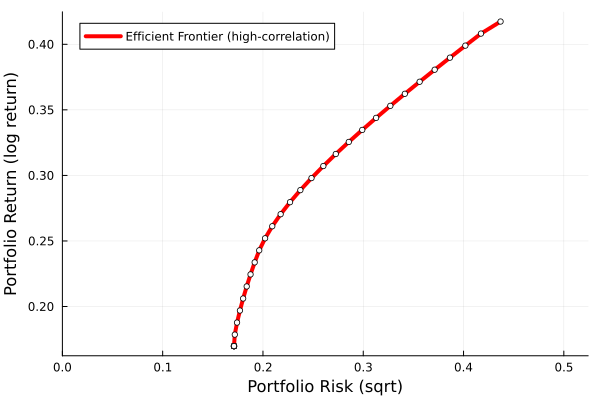

In [45]:
let
    plot(efficient_frontier_high_correlation, lw=4, xlabel="Portfolio Risk (sqrt)", 
        ylabel="Portfolio Return (log return)", fontsize=18, label="Efficient Frontier (high-correlation)", c=:red, 
        xlim=(0.0, 1.2*maximum(efficient_frontier_high_correlation).first))
    scatter!(efficient_frontier_high_correlation, label="", c=:white, mec=:black, ms=3)
end

## Task 3: Compute the efficient frontier for the `low` correlation collection of tickers
Similar to the previous `high` correlation case, let's look up the position of the `low` correlation tickers in the `list_of_all_tickers` list and save these values in the `my_list_of_firm_ids_lc` variable.

In [47]:
my_list_of_firm_ids_lc = Array{Int64,1}();
for ticker ∈ my_low_correlation_ticker_array
    firm_index = findfirst(x->x==ticker, list_of_all_tickers);    
    push!(my_list_of_firm_ids_lc, firm_index)
end

Then, let's build an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) using the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}) for the `low` correlation collection of tickers, passing in the data for the required fields for the `low` correlation portfolio. Store this problem object in the `problem_risk_low_correlation` variable.
* `Note`: We are again using the shortcut syntax to extract the correct covariance array `Σ` and the expected return vector `μ`. We pass in the indexes for the firms we are interested in (stored in the `my_list_of_firm_ids_hc` variable), and the correct version of the data gets returned from the shortcut methods.

In [49]:
problem_risk_low_correlation = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ(my_list_of_firm_ids_lc), # short-cut: extracts the correct covariance,
    μ = μ(my_list_of_firm_ids_lc), # short-cut: extracts the correct expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for`-loop. In particular, for each pass through the loop, we:
* Update the `problem_risk_low_correlation` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier_low_correlation` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier_low_correlation` dictionary.

In [51]:
efficient_frontier_low_correlation = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_low_correlation.R = minimum_desired_reward_array[i];

    try
        solution = solve(problem_risk_low_correlation)
        status_flag = solution["status"];
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution["objective_value"]);
            efficient_frontier_low_correlation[key] = solution["reward"];
        end
    catch err
        println("Failed: desired R = $(problem_risk_low_correlation.R). Infeasible");
    end
end
efficient_frontier_low_correlation;

Failed: desired R = 0.42653061224489797. Infeasible
Failed: desired R = 0.4357142857142857. Infeasible
Failed: desired R = 0.4448979591836735. Infeasible
Failed: desired R = 0.45408163265306123. Infeasible
Failed: desired R = 0.463265306122449. Infeasible
Failed: desired R = 0.47244897959183674. Infeasible
Failed: desired R = 0.4816326530612245. Infeasible
Failed: desired R = 0.49081632653061225. Infeasible
Failed: desired R = 0.5. Infeasible


### Visualize the `low-` versus the `high-correlation` efficient frontier
`Unhide` the code block below to see how we plotted the `low-` and `high-correlation` portfolios constructed using the same `base_ticker_array` and `minimum_desired_reward_array.`

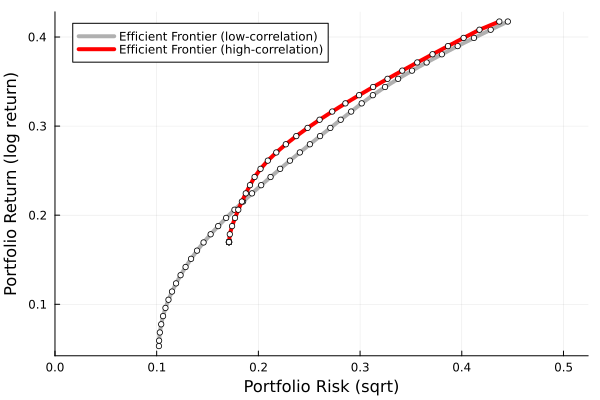

In [53]:
plot(efficient_frontier_low_correlation, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Return (log return)", fontsize=18, label="Efficient Frontier (low-correlation)", c=:gray69, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_low_correlation).first))
scatter!(efficient_frontier_low_correlation, label="", c=:white, mec=:black, ms=3)

plot!(efficient_frontier_high_correlation, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Return (log return)", fontsize=18, label="Efficient Frontier (high-correlation)", c=:red, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_high_correlation).first))
scatter!(efficient_frontier_high_correlation, label="", c=:white, mec=:black, ms=3)

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.